# Starting cluster

## Prerequisites
First, you need to install MPI, on windows use MS-MPI:
https://msdn.microsoft.com/en-us/library/bb524831(v=vs.85).aspx


## With a profile (not working)
In theory, you should be able to create a profile using
```
ipython profile create --parallel --profile=myprofile
```
and then set
```
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
```
in ```<IPYTHON-DIR>/profile_myprofile/ipcluster_config.py```. This should then enable you to start a cluster using
```
ipcluster start --profile=myprofile
```
or alternatively through the Clusters tab in Jupyter


## Without a profile (not working)
An alternative is to run
```
ipcluster start --engines=MPI
```


## Manual start (working)
This, however, does *not* work for me on Windows. What does work is the following:

Start a controller using
```
ipcontroller --ip='*'
```
and then start several engines using mpiexec:
```
mpiexec -n 4 ipengine --mpi
```

In [1]:
import ipyparallel

# attach to a running cluster
cluster = ipyparallel.Client()#profile='mpi')

print('profile:', cluster.profile)
print('Number of ids:', len(cluster.ids))
print("IDs:", cluster.ids) # Print process id numbers

profile: default
Number of ids: 4
IDs: [0, 1, 2, 3]


In [2]:
%%px

from mpi4py import MPI

comm = MPI.COMM_WORLD

print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))

comm.Barrier()   # wait for everybody to synchronize _here_

[stdout:4] Hello! I'm rank 3 from 4 running in total...
[stdout:5] Hello! I'm rank 2 from 4 running in total...
[stdout:6] Hello! I'm rank 0 from 4 running in total...
[stdout:7] Hello! I'm rank 1 from 4 running in total...


In [3]:
%%px

from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

print("Starting")
# passing MPI datatypes explicitly
if rank == 0:
    data = numpy.arange(100, dtype='i')
    numpy.random.shuffle(data)
    comm.Send([data, MPI.INT], dest=1, tag=77)
    print("{0}: sent data to 1: {1}".format(rank, data))
elif rank == 1:
    data = numpy.empty(100, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print("{0}: received data from 0: {1}".format(rank, data))
else:
    print("{0}: idle".format(rank))

[stdout:0] 
Starting
0: sent data to 1: [50 12 75 81 54 46 86 30 29 95  7 34 62 42 71 58 39 93 43  9 38 37 45 87
 65  8  3 91 63 53 96 66 35 24 88 60 59 98 32 15 74 57 69 72 82 19 47  2
 61 64 11 79  5 28 40 83 48 36 70 55 16 49 10  1 90  6 89 78 41 80 56 84
 97 17 67 99 26 14 73  0 27 22 13 94 23 85 33 51 68 18 44 25 77  4 20 92
 52 31 21 76]
[stdout:1] 
Starting
1: received data from 0: [50 12 75 81 54 46 86 30 29 95  7 34 62 42 71 58 39 93 43  9 38 37 45 87
 65  8  3 91 63 53 96 66 35 24 88 60 59 98 32 15 74 57 69 72 82 19 47  2
 61 64 11 79  5 28 40 83 48 36 70 55 16 49 10  1 90  6 89 78 41 80 56 84
 97 17 67 99 26 14 73  0 27 22 13 94 23 85 33 51 68 18 44 25 77  4 20 92
 52 31 21 76]
[stdout:2] 
Starting
2: idle
[stdout:3] 
Starting
3: idle


In [4]:
%%px

#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [5]:
%%px 

%cuda_context_handler cuda_context

In [6]:
%%px

def gen_test_data(nx, ny, g, num_ghost_cells):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    
    comm = MPI.COMM_WORLD

    #Create a gaussian "dam break" that will not form shocks
    size = width / 3.0
    dt = 10**10
    for j in range(-num_ghost_cells, ny+num_ghost_cells):
        for i in range(-num_ghost_cells, nx+num_ghost_cells):
            x = dx*(i+0.5) - x_center
            y = dy*(j+0.5) - y_center
            
            h[j+num_ghost_cells, i+num_ghost_cells] = 0.5 + 0.1*(comm.rank + np.exp(-(x**2/size)))
            hu[j+num_ghost_cells, i+num_ghost_cells] = 0.1*np.exp(-(x**2/size))
    
    max_h_estimate = comm.rank* 0.1 + 0.6
    max_u_estimate = 0.1*2.0
    dt = min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

In [7]:
%%px

# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": cuda_context,
"nx": 200, "ny": 100,
"dx": 200.0, "dy": 200.0,
"dt": 1,
"g": 9.81,
"f": 0.0,
"r": 0.0
}

[stdout:4] 
addLowerLeftBump
halo [0, 0, 0, 0]
nx 200
ny 100


[output:4]

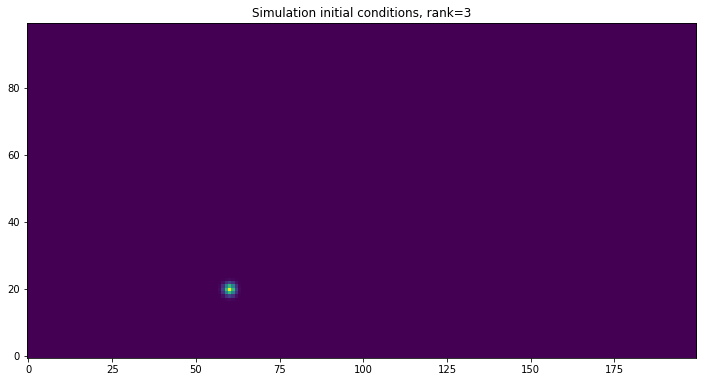

[output:5]

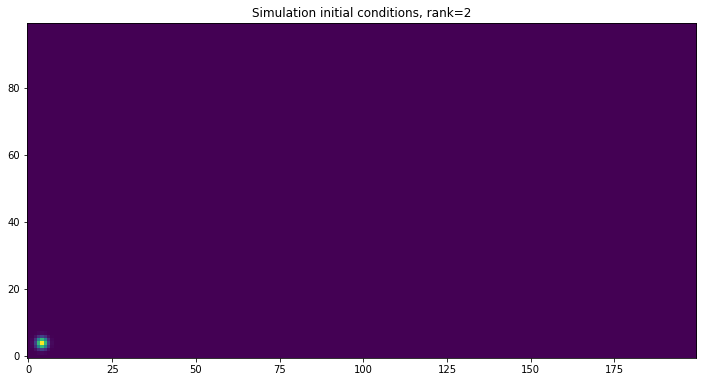

[output:6]

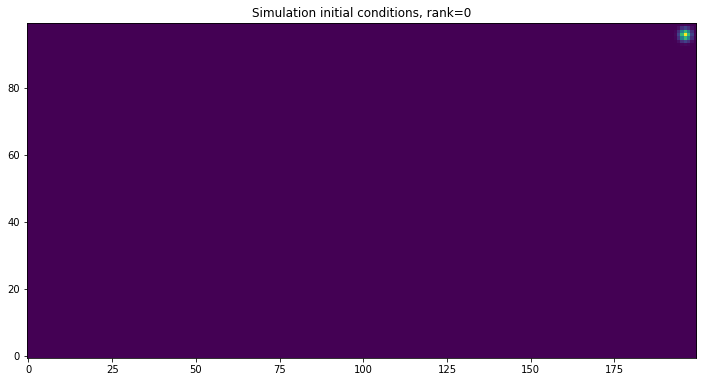

[output:7]

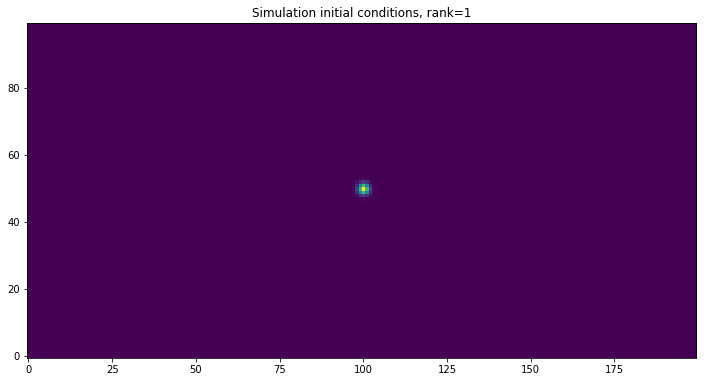

Out[4:7]: Text(0.5,1,'Simulation initial conditions, rank=3')

Out[5:7]: Text(0.5,1,'Simulation initial conditions, rank=2')

Out[6:7]: Text(0.5,1,'Simulation initial conditions, rank=0')

Out[7:7]: Text(0.5,1,'Simulation initial conditions, rank=1')

In [8]:
%%px 

ghosts = [0,0,0,0] # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
    
h0 = np.ones(dataShape, dtype=np.float32) * 60
eta0 = np.zeros(dataShape, dtype=np.float32)
hu0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32)
hv0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32)
    
#Create bump in to lower left of domain for testing
if (comm.rank == 0):
    addUpperCornerBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
if (comm.rank == 1):
    addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
if (comm.rank == 2):
    addCornerBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
if (comm.rank == 3):
    addLowerLeftBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
    

plt.figure(figsize=(12, 8))
plt.imshow(eta0, origin='lower')
plt.title("Simulation initial conditions, rank=" + str(comm.rank))

[output:4]

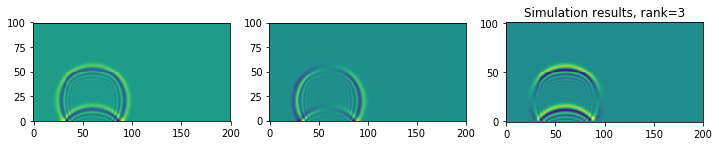

[output:5]

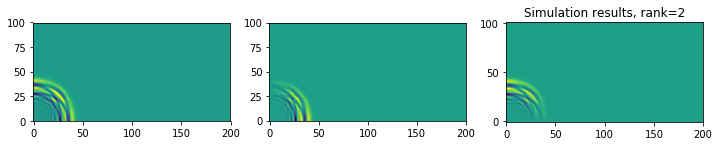

[output:6]

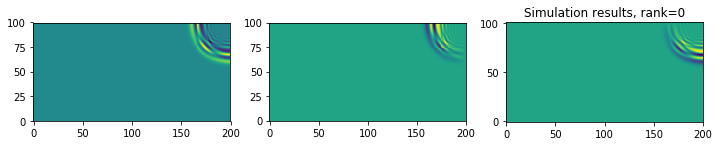

[output:7]

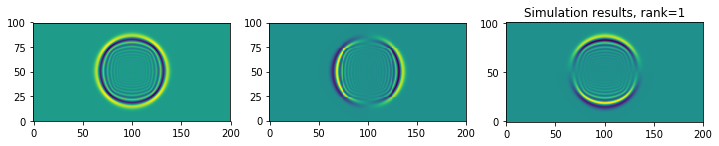

In [9]:
%%px


#Initialize simulator
fbl_args = {"H": h0, "eta0": eta0, "hu0": hu0, "hv0": hv0}
sim = FBL.FBL(**fbl_args, **sim_args)

#Run a simulation and plot it
sim.step(300)
eta1, hu1, hv1 = sim.download(interior_domain_only=True)

plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)
plt.imshow(eta1, origin='lower')
plt.subplot(1,3,2)
plt.imshow(hu1, origin='lower')
plt.subplot(1,3,3)
plt.imshow(hv1, origin='lower')
plt.title("Simulation results, rank=" + str(comm.rank))
plt.show()